## 决策树与K近邻分类

##### 分别使用 决策树 和 最近邻方法在分类任务上构建模型， 并通过交叉验证对模型进行调优
- 决策树
- 最近邻方法
- 交叉验证

> 机器学习定义： 假设用 P 来评估计算机程序在某任务类 T 上的性能，若一个程序利用经验 E 在任务 T 上获得了性能改善，则我们就说关于 T 和 P, 该程序对 E 进行了学习。

> 经验 E 指的是数据（没有数据我们什么也干不了）。
>> 根据训练方式，机器学习算法可以分为监督（supervised）和无监督（unsupervised）两类。
- 无监督学习需要训练含有很多特征的数据集，然后学习出这个数据集上有用的结构性质。
-  监督学习的数据集除了含有很多特征外，它的每个样本都要有一个标签（label）或目标（target）。

#### 在不同的问题设定下，T、P、E 可能指完全不同的东西。机器学习中一些流行的任务 T 包括：
- 分类：基于特征将实例分为某一类。
- 回归：基于实例的其他特征预测该实例的数值型目标特征。
- 聚类：基于实例的特征实现实例的分组，从而让组内成员比组间成员更为相似。
- 异常检测：寻找与其他样本或组内实例有很大区别的实例。
- 其他更多任务

### 分类和回归，属于监督学习
#### 例如：
- 信贷机构 希望根据用户累积的数据预测贷款违约情况
 - 此时E 就是已有的训练数据，即实例（客户）的集合， 一组特征（如：年龄、薪水、贷款类型、以往的违约记录） ； 一个目标（是否会违约） ； 
 - 由于需预测的目标变量是---是否会违约，此时就是一个二分类问题
 - 如果转而预测 贷款会超期多久，目标变量---一个超期的连续时间，此时就是一个回归问题

### 决策树

#### 分类问题中其他的分割质量标准

- 基尼不确定性（Gini uncertainty）：$G = 1 - \sum\limits_k (p_k)^2$
- 错分率（Misclassification error）：$E = 1 - \max\limits_k p_k$

##### 二元分类问题的熵和基尼不确定性为：
 
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})}$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+)$$

- 其中 $p_+$ 是对象具有标签 + 的概率。
- 以 $p_+$ 为坐标，绘制上面两个函数的图像。

In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
warnings.filterwarnings('ignore')

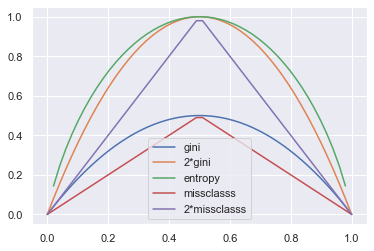

In [2]:
plt.figure(figsize=(6,4))
xx = np.linspace(0,1,50)
plt.plot(xx,[2 * x * (1-x) for x in xx] ,label='gini')
plt.plot(xx,[4 * x * (1-x) for x in xx] ,label='2*gini')
plt.plot(xx,[-x * np.log2(x) - (1-x)*np.log2(1-x)  for x in xx] ,label='entropy')
plt.plot(xx,[1-max(x,1-x) for x in xx] ,label='missclasss')
plt.plot(xx,[2-2* max(x,1-x) for x in xx] ,label='2*missclasss')
plt.legend()

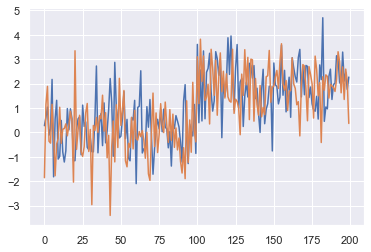

In [3]:
# 使用决策树拟合一些合成数据
## 第一类
np.random.seed(17)
train_data = np.random.normal(size=(100,2))
train_data
train_labels = np.zeros(100)
train_labels

## 第二类
train_data = np.r_[train_data, np.random.normal(size=(100,2), loc=2)]
train_labels = np.r_[train_labels,np.ones(100)]
train_labels
plt.plot(train_data)

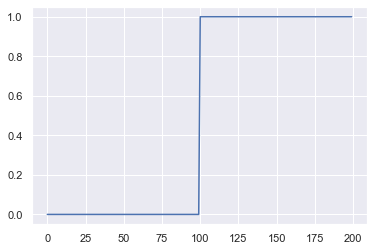

In [4]:
plt.plot(train_labels)

##### 为分类问题构造一个边界， 能较好的分开两个类别（红点、黄点）

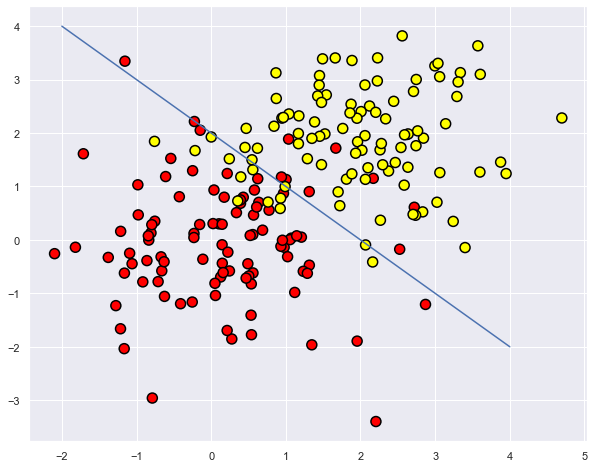

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(
    train_data[:,0], train_data[:,1], c= train_labels, s=100, cmap='autumn' , edgecolors='black' , linewidth=1.5
)
plt.plot(range(-2,5), range(4,-3,-1))

In [10]:
train_data.shape

(200, 2)

##### 训练一颗sklearn决策树， 区分两类数据点 ， 最后可视化所得的边界

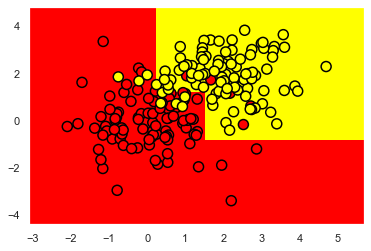

In [13]:
from sklearn.tree import DecisionTreeClassifier

def get_grid(data):
    x_min, x_max = data[:,0].min()-1 , data[:,0].max()+1
    y_min, y_max = data[:,1].min()-1 , data[:,1].max()+1
    return np.meshgrid(np.arange(x_min,x_max,0.01), np.arange(y_min,y_max,0.01))

# max_depth参数限制决策树的深度
clf_tree = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=17)

# 训练决策树
clf_tree.fit(train_data,train_labels)

# 可视化
xx,yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx,yy,predicted, cmap='autumn')
plt.scatter(train_data[:,0],train_data[:,1], c=train_labels, s=100, cmap='autumn', edgecolors='black' ,linewidths=1.5)

- 通过 pydotplus 和 export_graphviz 库我们可以方便的看到决策树本身是怎样的。
- 使用 `StringIO()` 函数开辟一个缓存空间保存决策树，
- 通过 `export_graphviz()` 函数以 DOT 格式导出决策树的 GraphViz 表示，然后将其写入 out_file 中。
- 使用 `graph_from_dot_data()` 函数读入数据并通过 `Image()` 函数显示决策树。

In [14]:
!pip install pydotplus -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24572 sha256=af62995490a346d07f3ddc9095104c3d2b6af7004a9c9e765699e8b9ad394a86
  Stored in directory: c:\users\ysilhouette\appdata\local\pip\cache\wheels\cf\43\cf\4c2d7a4e51b5a4753af5c8fa7da554592c1d19eb912ce51949
Successfully built pydotplus


In [19]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree,feature_names=['x1','x2'],
                out_file= dot_data, filled=True
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

InvocationException: GraphViz's executables not found

#### 决策树应用到数值特征

In [20]:
data = pd.DataFrame({'Age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
                     'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [21]:
data.sort_values('Age')

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0
